In [1]:
%matplotlib inline

import pandas as pd
import numpy as np
import glob
import os
import time
import pickle
import datetime
import networkx as nx

import sys
sys.path.append('/home/ngrav/project/')
from wearables.scripts import utils as wearutils
from wearables.scripts import data as weardata
from wearables.scripts import train as weartrain
from wearables.scripts import eval_ as weareval
from wearables.scripts import model as wearmodels
from wearables.scripts import DTW as weardtw
from wearables.scripts import error_analysis as wearerr

import torch
import torch.nn as nn
import torch.nn.functional as F

from scipy.stats import spearmanr
from scipy.stats import chi2_contingency
from scipy.stats import kruskal
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier
from sktime.datatypes._panel._convert import from_2d_array_to_nested
from sktime.regression.compose._ensemble import ComposableTimeSeriesForestRegressor
from sktime.classification.compose import ComposableTimeSeriesForestClassifier

import matplotlib.pyplot as plt
import seaborn as sns
from adjustText import adjust_text
plt.rc('font', size = 9)
plt.rc('font', family='sans serif')
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42
plt.rcParams['legend.frameon']=False
plt.rcParams['axes.grid']=False
plt.rcParams['legend.markerscale']=1
plt.rcParams['savefig.dpi'] = 600
sns.set_style("ticks")

In [2]:
def loadpkl(fp):
    with open(fp, 'rb') as f:
        return pickle.load(f)

In [3]:
# load data

pfp = '/home/ngrav/project/wearables/results/'
mfp = '/home/ngrav/project/wearables/model_zoo'

# filepaths to bst or pre-processed md with calculated metrics 
pp_md_fp = os.path.join(pfp, 'md_v522_220124.csv')
bst_trainer = os.path.join(mfp, 'trainer_itv52_InceptionTime_GA5.pkl')
bst_modelpkl = os.path.join(mfp, '213-itv52_InceptionTime_GA5.pkl')

# load up to date md
md = pd.read_csv(pp_md_fp, index_col=0)
trainer = loadpkl(bst_trainer)

if False:
    # call eval to get output, modify for return_hidden = True option
    evaluation = weareval.eval_trained(trainer, split='train',
                                       modelpkl=bst_modelpkl,
                                       two_outputs=True)

# show error in train and test set 

In [4]:
# define parameters
idxs = trainer.data.train_ids
threshold = 10 # for error groups

savefigs = False

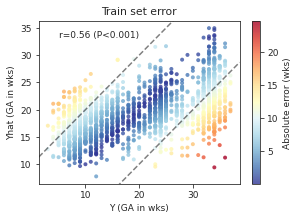

In [5]:
# parse data and plot
y = md.loc[idxs, 'y']
yhat = md.loc[idxs, 'yhat']
error = md.loc[idxs, 'error']

fig, ax = plt.subplots(1, 1, figsize=(4.5, 3))
im = ax.scatter(y, yhat, c=error.abs(), cmap='RdYlBu_r', linewidth=0, s=16, alpha=0.8)
fig.colorbar(im, ax=ax, label='Absolute error (wks)')
x0, x1 = ax.get_xlim()
y0, y1 = ax.get_ylim()
ax.plot([x0, x1], [x0+threshold, x1+threshold], 'k--', alpha=0.5)
ax.plot([x0, x1], [x0-threshold, x1-threshold], 'k--', alpha=0.5)
ax.set_xlim([x0, x1])
ax.set_ylim([y0, y1])
rho, p = spearmanr(y, yhat)
p_txt = 'P={:.2f}'.format(p) if p > 0.001 else 'P<0.001'
ax.text(0.1, 0.9, 'r={:.2f} ({})'.format(rho, p_txt), transform=ax.transAxes) 
ax.set_xlabel('Y (GA in wks)')
ax.set_ylabel('Yhat (GA in wks)')
ax.set_title('Train set error')

if savefigs:
    fig.savefig(os.path.join(pfp, 'scatter_yhatVy_train.pdf'), bbox_inches='tight')

### assign error grp

In [6]:
md['Error group'] = 'lt{}wks'.format(threshold)
md.loc[(md['error'] >= threshold), 'Error group'] = 'Higher-than-actual'
md.loc[(md['error'] <= -threshold), 'Error group'] = 'Lower-than-actual'


In [7]:
md.loc[idxs, 'Error group'].value_counts()

lt10wks               1300
Lower-than-actual      267
Higher-than-actual     159
Name: Error group, dtype: int64

In [8]:
errgrp_cmap = {'lt{}wks'.format(threshold): '#4297A0', # green
               'Higher-than-actual': '#E57F84', #red
               'Lower-than-actual': '#2F5061', # blue
               }

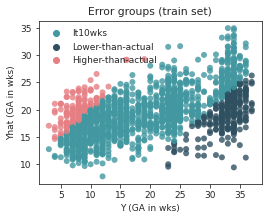

In [9]:
fig, ax = plt.subplots(1, 1, figsize=(4, 3))
sns.scatterplot(x='y', y='yhat', hue='Error group', data=md.loc[idxs], palette=errgrp_cmap, linewidth=0, alpha=0.8, ax=ax)
ax.set_xlabel('Y (GA in wks)')
ax.set_ylabel('Yhat (GA in wks)')
ax.set_title('Error groups (train set)')
ax.legend().set_title('')

if savefigs:
    fig.savefig(os.path.join(pfp, 'scatter_yhatVy_train_errorgroups.pdf'), bbox_inches='tight')

## chk the same in the test set m

In [10]:
# define parameters
idxs = trainer.data.test_ids

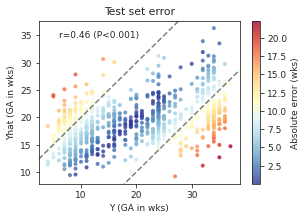

In [11]:
# parse data and plot
y = md.loc[idxs, 'y']
yhat = md.loc[idxs, 'yhat']
error = md.loc[idxs, 'error']

fig, ax = plt.subplots(1, 1, figsize=(4.5, 3))
im = ax.scatter(y, yhat, c=error.abs(), cmap='RdYlBu_r', linewidth=0, s=16, alpha=0.8)
fig.colorbar(im, ax=ax, label='Absolute error (wks)')
x0, x1 = ax.get_xlim()
y0, y1 = ax.get_ylim()
ax.plot([x0, x1], [x0+threshold, x1+threshold], 'k--', alpha=0.5)
ax.plot([x0, x1], [x0-threshold, x1-threshold], 'k--', alpha=0.5)
ax.set_xlim([x0, x1])
ax.set_ylim([y0, y1])
rho, p = spearmanr(y, yhat)
p_txt = 'P={:.2f}'.format(p) if p > 0.001 else 'P<0.001'
ax.text(0.1, 0.9, 'r={:.2f} ({})'.format(rho, p_txt), transform=ax.transAxes) 
ax.set_xlabel('Y (GA in wks)')
ax.set_ylabel('Yhat (GA in wks)')
ax.set_title('Test set error')

if savefigs:
    fig.savefig(os.path.join(pfp, 'scatter_yhatVy_test.pdf'), bbox_inches='tight')

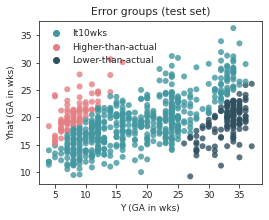

In [12]:
fig, ax = plt.subplots(1, 1, figsize=(4, 3))
sns.scatterplot(x='y', y='yhat', hue='Error group', data=md.loc[idxs], palette=errgrp_cmap, linewidth=0, alpha=0.8, ax=ax)
ax.set_xlabel('Y (GA in wks)')
ax.set_ylabel('Yhat (GA in wks)')
ax.set_title('Error groups (test set)')
ax.legend().set_title('')

if savefigs:
    fig.savefig(os.path.join(pfp, 'scatter_yhatVy_test_errorgroups.pdf'), bbox_inches='tight')

In [13]:
md.loc[idxs, 'Error group'].value_counts()

lt10wks               518
Lower-than-actual     129
Higher-than-actual     90
Name: Error group, dtype: int64

# md differences across err grp

In [14]:
# grab list of vars to predict (mdpred_voi)
from wearables.scripts.md_specification import mdpred_voi

In [15]:
import importlib
importlib.reload(wearutils)

<module 'wearables.scripts.utils' from '/home/ngrav/project/wearables/scripts/utils.py'>

In [16]:
resknn10 = loadpkl(os.path.join(pfp, 'md_predictability_knn_10wk.pkl'))
# resknn8 = loadpkl(os.path.join(pfp, 'md_predictability_knn_8wk.pkl'))

In [17]:
moi = wearutils.metric_list(resknn10, mdpred_voi, top1=True) #, clf_metric='balanced_acc')
# moi = wearutils.metric_list(resknn8, mdpred_voi)

In [18]:
savefigs = True

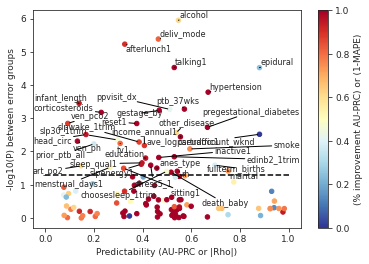

In [30]:
fig, ax = plt.subplots(1, 1, figsize=(6, 4))
# p_threshold = -np.log10(0.05/len(mdpred_voi.keys())) # bonferroni
p_threshold = -np.log10(0.05)
clip_color=True
texts = []
x, y, c = [], [], []
for k in moi.keys():
    x.append(moi[k][1])
    y.append(moi[k][0])
    c.append(moi[k][2])
    if moi[k][0] > p_threshold:
        texts.append(ax.text(moi[k][1], moi[k][0], k, size=8))
im = ax.scatter(x, y, c=c, cmap='RdYlBu_r', s=20, vmin=0, vmax=1)
fig.colorbar(im, ax=ax, label='(% improvement AU-PRC) or (1-MAPE)')
ax.plot([0, 1], [p_threshold, p_threshold], 'k--')
adjust_text(texts, arrowprops=dict(arrowstyle='-', color='k'), force_text=(0.12, 0.3))
ax.set_xlabel('Predictability (AU-PRC or |Rho|)')
ax.set_ylabel('-log10(P) between error groups')

if savefigs:
    fig.savefig(os.path.join(pfp, 'scatter_errgroupdiffVpredictability_knn.pdf'), bbox_inches='tight')

# corrnet

In [19]:
from scipy.stats import spearmanr
from sklearn.linear_model import LogisticRegression
import sklearn.metrics as sklmetrics
from sklearn.exceptions import ConvergenceWarning

In [20]:
def tabular_corrnet(md, mdpred_voi, edge_w_threshold=0.5):
    '''Calculate correlations (will need to take absolute value) for cont-cont using Spearman's rho,
         cont-cat using logistic regression on the categorical (max of balanced acc, adj., i.e., Youden's J),
         and Goodman Kruskal gamma for cat-cat variable comparisons.
    
    Arguments:
      md (pd.DataFrame): of mixed categorical and continuous variables. Must have a split column specifying train and
        test splits so logistic regression can be run
      mdpred_voi (dict): specify name of column in md as a key and the type of var as a value, accepts 'continuous' or 'categorical' 
        values in order to trigger the appropriate analysis.
        
    Returns:
      pd.DataFrame, nx.Graph
    '''
    from scipy.stats import spearmanr
    from sklearn.linear_model import LogisticRegression
    import sklearn.metrics as sklmetrics
    from sklearn.exceptions import ConvergenceWarning
    variables = list(mdpred_voi.keys())
    df = pd.DataFrame(index=variables, columns=variables)
    for i in range(len(variables)):
        for j in range(len(variables)):
            if i<=j:
                continue
            else:
                k, kk = variables[i], variables[j]
                v, vv = mdpred_voi[k], mdpred_voi[kk]
                if v == 'continuous' and vv == 'continuous':
                    # spearman's rho 
                    rho, p = spearmanr(md[k], md[kk])
                    df.loc[k, kk] = rho
                    df.loc[kk, k] = rho
                elif (v == 'continuous' and vv == 'categorical') or (v == 'categorical' and vv == 'continuous'):
                    # logistic regression
                    contvar = k if v == 'continuous' else kk
                    catvar = k if v == 'categorical' else kk
                    X_train = md.loc[md['split']=='train', contvar].to_numpy(dtype=np.float64).reshape(-1, 1)
                    X_test = md.loc[md['split']=='test', contvar].to_numpy(dtype=np.float64).reshape(-1, 1)
                    y_train = md.loc[md['split']=='train', catvar]
                    y_test = md.loc[md['split']=='test', catvar]
                    if len(y_train.unique()) < 1:
                        print(f"only one val found for {catvar}")
                    elif len(y_train.unique()) > 2:
                        y_train = y_train.to_numpy(dtype=int)
                        y_test = y_test.to_numpy(dtype=int)
                        y_train_wide = np.zeros((y_train.shape[0], len(np.unique(y_train))), dtype=int)
                        y_test_wide = np.zeros((y_test.shape[0], len(np.unique(y_train))), dtype=int)
                        y_train_wide[np.arange(y_train.shape[0]), y_train] = 1
                        y_test_wide[np.arange(y_test.shape[0]), y_test] = 1

                        y_train = y_train_wide
                        del y_train_wide
                        y_test = y_test_wide 
                        del y_test_wide
                    else:
                        y_train = y_train.to_numpy(dtype=int).reshape(-1, 1)
                        y_test = y_test.to_numpy(dtype=int).reshape(-1, 1)
                    balanced_acc = [] # Youden's J
                    for j in range(y_train.shape[1]):
                        lr = LogisticRegression(penalty='elasticnet', solver='saga', l1_ratio=0.1)
                        lr.fit(X_train, y_train[:, j])
                        balanced_acc.append(
                            sklmetrics.balanced_accuracy_score(y_test[:, j], lr.predict(X_test), adjusted=True)
                        )
                    df.loc[k, kk] = np.max(balanced_acc) # max agg?
                    df.loc[kk, k] = np.max(balanced_acc) # max agg?
                else:
                    # cat v. cat
                    GKgamma = wearerr.goodmanKruskalgamma(md, k, kk)
                    df.loc[k, kk] = GKgamma 
                    df.loc[kk, k] = GKgamma
    return df
            
                
            

In [21]:
df = tabular_corrnet(md, mdpred_voi)

/home/ngrav/miniconda3/envs/wearables/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/home/ngrav/miniconda3/envs/wearables/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/home/ngrav/miniconda3/envs/wearables/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/home/ngrav/miniconda3/envs/wearables/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/home/ngrav/miniconda3/envs/wearables/li

/home/ngrav/miniconda3/envs/wearables/lib/python3.8/site-packages/seaborn/matrix.py:649: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/home/ngrav/miniconda3/envs/wearables/lib/python3.8/site-packages/seaborn/matrix.py:619: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage = hierarchy.linkage(self.array, method=self.method,


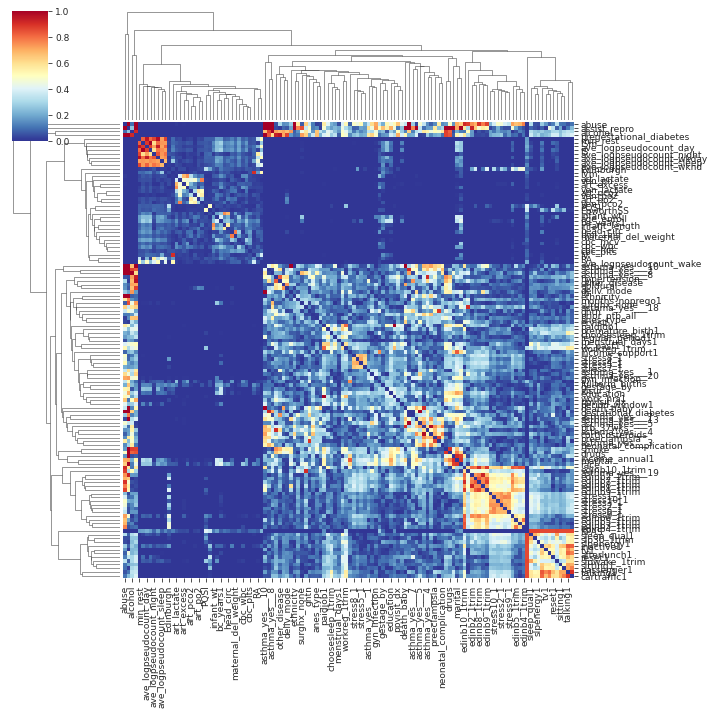

In [36]:
p = sns.clustermap(df.fillna(0).abs(), yticklabels=1, xticklabels=2, cmap='RdYlBu_r')
# p.savefig(os.path.join(pfp, 'md_corrnet_v2.pdf'), bbox_inches='tight')


## pval only

Size and color by pval across error groups

In [22]:
corr_threshold = 0.6
G = nx.Graph()
for k, v in moi.items():
    G.add_node(k, size=v[0], color=v[0])
variables = df.columns.to_list()
for i in range(len(variables)):
    for j in range(len(variables)):
        if i <= j: 
            continue
        else: 
            k, kk = variables[i], variables[j]
            w = np.abs(df.loc[k, kk])
            if w > corr_threshold:
                G.add_edge(k, kk, weight=w)
G.remove_nodes_from(list(nx.isolates(G)))
pos = nx.spring_layout(G, k=0.5)


In [26]:
p_threshold = -np.log10(0.05)

In [23]:
def range_scale(x, min_target=100, max_target=300):
    return ((x - np.min(x)) / (np.max(x) - np.min(x)))*(max_target - min_target) + min_target

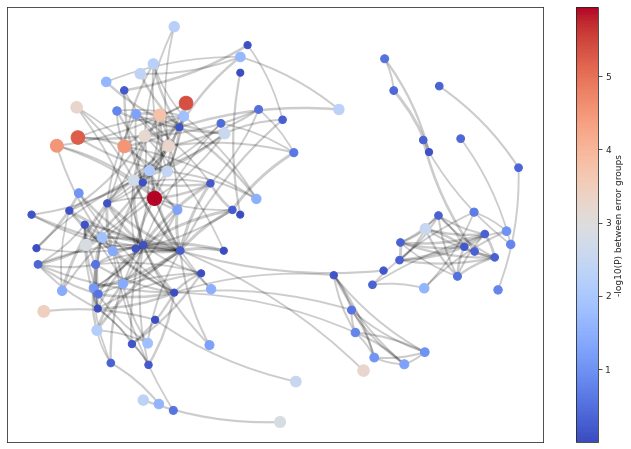

In [24]:
# plot
fig, ax = plt.subplots(1, 1, figsize=(12, 8))
node_sizes = [G.nodes[n]['size'] for n in G.nodes()]
im = nx.draw_networkx_nodes(
    G, pos=pos, label=False,
    nodelist=G.nodes(),
    node_color=[G.nodes[n]['color'] for n in G.nodes()],
    node_size=range_scale([G.nodes[n]['size'] for n in G.nodes()], min_target=50, max_target=200),
    cmap='coolwarm',
    ax=ax)
for edge in G.edges:
    ax.annotate('',
                xy=pos[edge[0]], 
                xytext=pos[edge[1]], 
                xycoords='data',
                textcoords='data',
                arrowprops=dict(arrowstyle="-", color='k',
                                linewidth=((np.exp(G.edges[edge]['weight']) - np.exp(0))/(np.exp(1) - np.exp(0)))*2.5+0.5, 
                                alpha=0.2,
                                shrinkA=0.5, shrinkB=0.5,
                                patchA=None, patchB=None,
                                connectionstyle="arc3,rad=-0.1",),
                zorder=0,
                )
if False:
    # show tecxt that is sig only?
    texts = []
    for k in moi.keys():
        if moi[k][0] > p_threshold and k in list(G.nodes):
            texts.append(ax.text(pos[k][0], pos[k][1], k, size=9))
    # adjust_text(texts, arrowprops=dict(arrowstyle='-', color='k'), force_text=(0.12, 0.3))
    adjust_text(texts, force_text=(0.12, 0.3))
fig.colorbar(im, ax=ax, label='-log10(P) between error groups')
fig.savefig(os.path.join(pfp, 'corrnet_sizePval_btwerrgrp_sigtxt.pdf'))

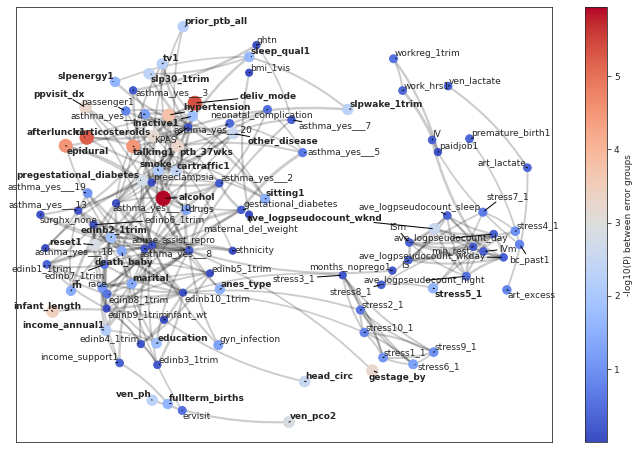

In [27]:
# plot
fig, ax = plt.subplots(1, 1, figsize=(12, 8))
im = nx.draw_networkx_nodes(
    G, pos=pos, label=False,
    nodelist=G.nodes(),
    node_color=[G.nodes[n]['color'] for n in G.nodes()],
    node_size=range_scale([G.nodes[n]['size'] for n in G.nodes()], min_target=50, max_target=200),
    cmap='coolwarm',
    ax=ax)
for edge in G.edges:
    ax.annotate('',
                xy=pos[edge[0]], 
                xytext=pos[edge[1]], 
                xycoords='data',
                textcoords='data',
                arrowprops=dict(arrowstyle="-", color='k',
                                linewidth=((np.exp(G.edges[edge]['weight']) - np.exp(0))/(np.exp(1) - np.exp(0)))*2.5+0.5, 
                                alpha=0.2,
                                shrinkA=0.5, shrinkB=0.5,
                                patchA=None, patchB=None,
                                connectionstyle="arc3,rad=-0.1",),
                zorder=0,
                )
if True:
    texts = []
    # all 
    for k in G.nodes():
        if moi[k][0] > p_threshold:
            weight='bold'
        else:
            weight='normal'
        texts.append(ax.text(pos[k][0], pos[k][1], k, size=9, weight=weight))
    adjust_text(texts, arrowprops=dict(arrowstyle='-', color='k'), force_text=(0.12, 0.3))
fig.colorbar(im, ax=ax, label='-log10(P) between error groups')
fig.savefig(os.path.join(pfp, 'corrnet_sizePval_btwerrgrp_alltxt.pdf'))

## pval and predictability

In [41]:
# update graph
for k in G.nodes:
    G.nodes[k]['size'] = moi[k][2] if not np.isnan(moi[k][2]) or np.isinf(moi[k][2]) else 0
    G.nodes[k]['color'] = moi[k][0]


KeyboardInterrupt: 

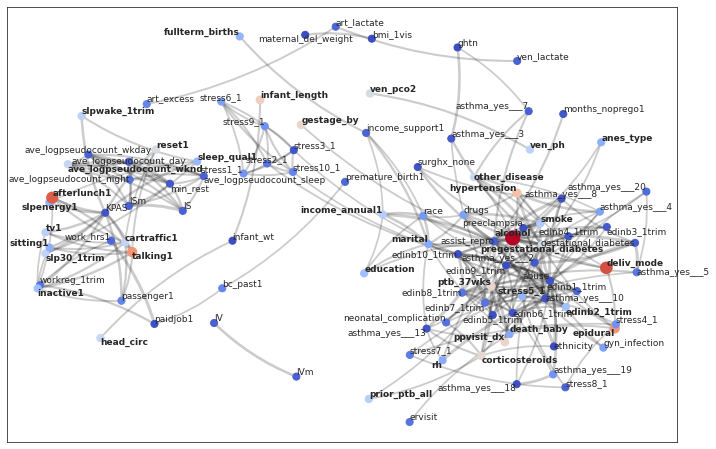

In [ ]:
# plot
fig, ax = plt.subplots(1, 1, figsize=(12, 8))
node_sizes = [G.nodes[n]['size'] for n in G.nodes()]
im = nx.draw_networkx_nodes(
    G, pos=pos, label=False,
    nodelist=G.nodes(),
    node_color=[G.nodes[n]['color'] for n in G.nodes()],
    node_size=range_scale(np.exp([G.nodes[n]['size'] for n in G.nodes()]), min_target=50, max_target=200),
    cmap='coolwarm',
    ax=ax)
for edge in G.edges:
    ax.annotate('',
                xy=pos[edge[0]], 
                xytext=pos[edge[1]], 
                xycoords='data',
                textcoords='data',
                arrowprops=dict(arrowstyle="-", color='k',
                                linewidth=((np.exp(G.edges[edge]['weight']) - np.exp(0))/(np.exp(1) - np.exp(0)))*2.5+0.5, 
                                alpha=0.2,
                                shrinkA=0.5, shrinkB=0.5,
                                patchA=None, patchB=None,
                                connectionstyle="arc3,rad=-0.1",),
                zorder=0,
                )
texts = []
# all 
for k in G.nodes():
    if moi[k][0] > p_threshold:
        weight='bold'
    else:
        weight='normal'
    texts.append(ax.text(pos[k][0], pos[k][1], k, size=9, weight=weight))
adjust_text(texts, arrowprops=dict(arrowstyle='-', color='k'), force_text=(0.12, 0.3))
fig.colorbar(im, ax=ax, label='-log10(P) between error groups')

In [ ]:
savefigs = True

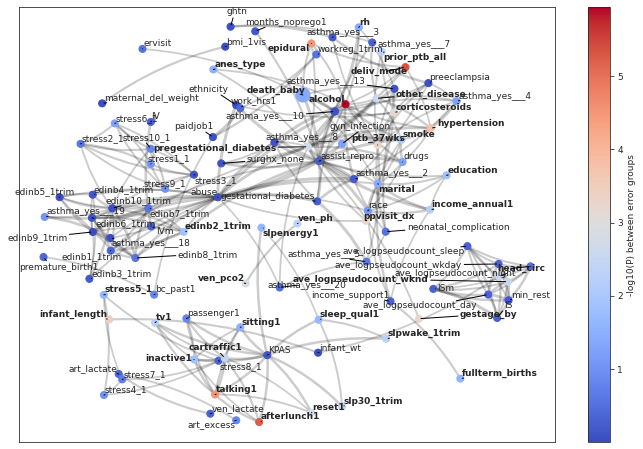

In [44]:
# plot
fig, ax = plt.subplots(1, 1, figsize=(12, 8))
node_sizes = [G.nodes[n]['size'] for n in G.nodes()]
im = nx.draw_networkx_nodes(
    G, pos=pos, label=False,
    nodelist=G.nodes(),
    node_color=[G.nodes[n]['color'] for n in G.nodes()],
    node_size=range_scale(np.exp([G.nodes[n]['size'] for n in G.nodes()]), min_target=50, max_target=200),
    cmap='coolwarm',
    ax=ax)
for edge in G.edges:
    ax.annotate('',
                xy=pos[edge[0]], 
                xytext=pos[edge[1]], 
                xycoords='data',
                textcoords='data',
                arrowprops=dict(arrowstyle="-", color='k',
                                linewidth=((np.exp(G.edges[edge]['weight']) - np.exp(0))/(np.exp(1) - np.exp(0)))*2.5+0.5, 
                                alpha=0.2,
                                shrinkA=0.5, shrinkB=0.5,
                                patchA=None, patchB=None,
                                connectionstyle="arc3,rad=-0.1",),
                zorder=0,
                )
texts = []
# all 
for k in G.nodes():
    if moi[k][0] > p_threshold:
        weight='bold'
    else:
        weight='normal'
    texts.append(ax.text(pos[k][0], pos[k][1], k, size=9, weight=weight))
adjust_text(texts, arrowprops=dict(arrowstyle='-', color='k'), force_text=(0.12, 0.3))
fig.colorbar(im, ax=ax, label='-log10(P) between error groups')

if savefigs:
    fig.savefig(os.path.join(pfp, 'mdcorrnet_errgrpP_informativenessSize.pdf'), bbox_inches='tight')

In [33]:
# color by node
from wearables.scripts.aesthetics import md_node_annotation

{'age_enroll': (0.4503032455735385, 0.293814430107942, 0.8495194544199904),
 'marital': (1.4138020753906977, 0.7522230681346815, 0.7358433347177544),
 'gestage_by': (3.2383729096964355, 0.4682851700685764, 1.2709398356101156),
 'insur': (0.2856918090850371, 0.5517931560539526, 2.2621733002067077),
 'ethnicity': (0.007364441243414597, 0.5319361277445109, 19.781491710868696),
 'race': (1.0821744727668512, 0.7747135740502399, 0.5452661761286247),
 'bmi_1vis': (0.000539619516303196, 0.14853768843186918, 0.7867907790186519),
 'prior_ptb_all': (2.2270923970388647,
  0.2003804321318831,
  0.36477781864129294),
 'fullterm_births': (1.5872157797434623,
  0.6970140600615493,
  0.3811803535280253),
 'surghx_none': (0.09750848179504104, 0.7512111167771545, 0.30768237458973985),
 'alcohol': (5.949928812445193, 0.5475385332234103, 0.6151609246576081),
 'smoke': (2.077415901765196, 0.5944620771691415, 0.7565608091555241),
 'drugs': (1.2675818034397575, 0.5742509828530109, 0.7221395550592439),
 'hyper

In [ ]:
md.groupby("group_ID")["value"].rank("dense", ascending=False)

# ptb specifics

## permutation tests per group



In [45]:
ptb_cmap = {False: '#2F5061', True: '#E57F84'}
sns.scatterplot(x='IS', y='error', data=md, hue='Pre-term birth', palette=)

,record_id,age_enroll,marital,gestage_by,insur,ethnicity,race,bmi_1vis,prior_ptb_all,fullterm_births,...,PQSI,KPAS,EpworthSS,Edinburgh,Pre-term birth,y,yhat,split,error,Error group
unique_id,,,,,,,,,,,,,,,,,,,,,
1024_10,1024,23.0,0.0,0.0,5.0,0.0,1.0,21.378954,0.0,1.0,...,4.0,4.571429,0.0,0.0,False,10.0,15.463044,train,5.463044,lt10wks
2180_12,2180,34.0,1.0,1.0,3.0,0.0,0.0,31.732640,0.0,0.0,...,10.0,9.053680,5.0,6.0,False,12.0,11.777130,train,-0.222870,lt10wks
2148_11,2148,34.0,1.0,2.0,3.0,0.0,0.0,22.406605,0.0,1.0,...,11.0,10.266234,9.0,7.0,False,11.0,18.814798,train,7.814798,lt10wks
1062_8,1062,31.0,0.0,1.0,5.0,0.0,1.0,40.106270,0.0,0.0,...,8.0,9.493074,3.0,5.0,False,8.0,14.428290,train,6.428290,lt10wks
1306_7,1306,25.0,0.0,3.0,5.0,0.0,1.0,24.555670,0.0,0.0,...,10.0,8.889610,9.0,9.0,False,7.0,16.641426,train,9.641426,lt10wks
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2344_32,2344,26.0,1.0,3.0,3.0,0.0,0.0,25.969303,0.0,0.0,...,11.0,11.025541,2.0,0.0,False,32.0,25.704956,train,-6.295044,lt10wks
2167_33,2167,31.0,1.0,2.0,3.0,0.0,0.0,29.672672,0.0,1.0,...,6.0,8.044805,11.0,0.0,False,33.0,20.061865,train,-12.938135,Lower-than-actual
1484_33,1484,28.0,1.0,2.0,1.0,0.0,1.0,30.598898,1.0,0.0,...,7.0,12.809957,11.0,2.0,True,33.0,24.141296,test,-8.858704,lt10wks


In [52]:
trainer.data.data['cat_class_enc']['income_annual1']

{'0': 0.0, '1': 1.0}

In [53]:
2**0.86

1.8150383106343217

In [30]:
tst = { 'edinb2_1trim': 'Social determinants of health',
 'edinb3_1trim': 'Social determinants of health',
 'edinb4_1trim': 'Social determinants of health',
 'edinb5_1trim': 'Social determinants of health',
 'edinb6_1trim': 'Social determinants of health',
 'edinb7_1trim': 'Social determinants of health',
 'edinb8_1trim': 'Social determinants of health',
 'edinb9_1trim': 'Social determinants of health',
 'edinb10_1trim': 'Social determinants of health',
 'IS': 'Social determinants of health',
 'IV': 'Social determinants of health',
 'ISm': 'Social determinants of health',
 'IVm': 'Social determinants of health',
 'min_rest': 'Social determinants of health',
 'ave_logpseudocount_sleep': 'Social determinants of health',
 'ave_logpseudocount_wknd': 'Social determinants of health',
 'ave_logpseudocount_wkday': 'Social determinants of health',
 'ave_logpseudocount_day': 'Social determinants of health',
 'ave_logpseudocount_night': 'Social determinants of health',
 'KPAS': 'Social determinants of health'}

In [31]:
{k:'Activity-related' if 'edin' not in k else 'Depression-related' for k in tst.keys()}

{'edinb2_1trim': 'Depression-related',
 'edinb3_1trim': 'Depression-related',
 'edinb4_1trim': 'Depression-related',
 'edinb5_1trim': 'Depression-related',
 'edinb6_1trim': 'Depression-related',
 'edinb7_1trim': 'Depression-related',
 'edinb8_1trim': 'Depression-related',
 'edinb9_1trim': 'Depression-related',
 'edinb10_1trim': 'Depression-related',
 'IS': 'Activity-related',
 'IV': 'Activity-related',
 'ISm': 'Activity-related',
 'IVm': 'Activity-related',
 'min_rest': 'Activity-related',
 'ave_logpseudocount_sleep': 'Activity-related',
 'ave_logpseudocount_wknd': 'Activity-related',
 'ave_logpseudocount_wkday': 'Activity-related',
 'ave_logpseudocount_day': 'Activity-related',
 'ave_logpseudocount_night': 'Activity-related',
 'KPAS': 'Activity-related'}